In [1]:
import os
import cv2
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

# Importing dataset
### Specifying important values

In [2]:
path = "myData" # dataset directory
labelFile = 'labels.csv' # class labels file
epochs_val = 10 # n. of epochs to run
batch_size_val = 50  # batch size
steps_per_epoch_val = 2000 # step per epoch
imgDims = (32,32,3) # dimensions of each image in dataset
testRatio = 0.2    # test/train ratio - 20% of images will be for testing
validationRatio = 0.2 # 20% of all training images will be for validation

### Importing images from dataset

In [3]:
count = 0

images = []
classNo = []

classList = os.listdir(path)
print("Total Classes Detected:",len(classList))
num_classes=len(classList)
print("Importing Classes:")

for x in range (0,len(classList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


### Splitting data into train/test/validation arrays

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)
 
# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID


### Checking everything is in order

In [8]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imgDims))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imgDims))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imgDims))," The dimesionas of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


### Reading labels file

In [9]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


### Data visualisation

In [20]:
# num_of_samples = []
# cols = 5
# fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
# fig.tight_layout()
# for i in range(cols):
#     for j,row in data.iterrows():
#         x_selected = X_train[y_train == j]
#         axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
#         axs[j][i].axis("off")
#         if i == 2:
#             axs[j][i].set_title(str(j)+ "-"+row["Name"])
#             num_of_samples.append(len(x_selected))
# print(num_of_samples)
# plt.figure(figsize=(12, 4))
# plt.bar(range(0, num_classes), num_of_samples)
# plt.title("Distribution of the training dataset")
# plt.xlabel("Class number")
# plt.ylabel("Number of images")
# plt.show()

### Data preprocessing and augmentation

In [22]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img =cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))

In [23]:
# image = cv2.imshow("GrayScale Images",X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY

#### Add depth of 1

In [24]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)


#### Augmentation to make data more generic

In [25]:
dataGen= ImageDataGenerator(width_shift_range=0.1,   
                            height_shift_range=0.1,
                            zoom_range=0.2,  
                            shear_range=0.1,  
                            rotation_range=10) 
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20) 
X_batch,y_batch = next(batches)

#### Visualisation of augmented data

In [26]:
# fig,axs=plt.subplots(1,15,figsize=(20,5))
# fig.tight_layout()
 
# for i in range(15):
#     axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
#     axs[i].axis('off')
# plt.show()

### Converting from class vector to binary class matrices
For categorical crossentropy

In [28]:
y_train = to_categorical(y_train,num_classes)
y_validation = to_categorical(y_validation,num_classes)
y_test = to_categorical(y_test,num_classes)

### Specifying and compiling model structure

In [32]:
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5)
    
    size_of_Filter2=(3,3)
    size_of_pool=(2,2) 
    no_Of_Nodes = 500   
    model= Sequential()
    
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imgDims[0],
                                                                imgDims[1],
                                                                1),activation='relu')))
    
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
 
    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))
 
    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='softmax'))

    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [33]:
steps_per_epoch_val = X_train.shape[0] // batch_size_val
validation_steps_val = X_test.shape[0] // batch_size_val
print(steps_per_epoch_val)

445


### Train model 

In [34]:
model = myModel()
print(model.summary())
history=model.fit(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1, batch_size=batch_size_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)         

### Model Prediction

In [35]:
prediction=model.predict(X_train)


In [37]:
# test = prediction.round()

# results = []

# for x in range(len(test)):
#   results.append([np.argmax(test[x])])

# for i in range(1000):
#     pred = np.argmax(test[i])
#     ans = np.argmax(y_test[i])
    
#     if (pred != ans):
#         plt.figure()
#         plt.title("prediction: " + classes[pred][1] + " -- actual: " + classes[ans][1])
#         plt.imshow(x_test[i])

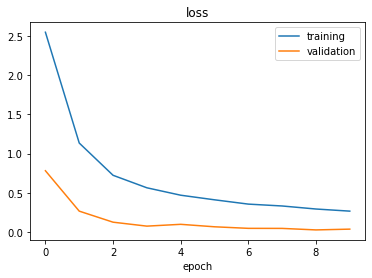

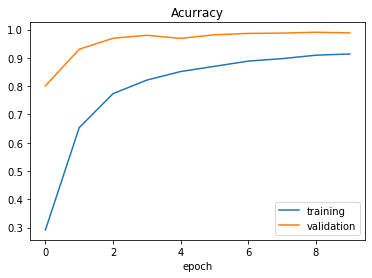

Test Score: 0.04659804329276085
Test Accuracy: 0.985775887966156


In [19]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])



In [26]:
print(X_test)

# import numpy as np
# X_test=np.argmax(y_test, axis=1)
# print(X_test[1])

y_true, y_pred = y_test, prediction

print(y_true)
print(y_pred)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
# Recall
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

[28 14  9 ... 23 11 18]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[6.5192670e-14 1.6810968e-09 9.9999988e-01 ... 4.7922507e-17
  3.9522621e-27 3.9060845e-26]
 [2.3600642e-21 3.2186534e-17 5.7327751e-16 ... 3.1713566e-07
  2.0091651e-15 1.4910356e-15]
 [2.6413848e-20 1.1913777e-14 1.0000000e+00 ... 8.5297018e-23
  3.4628947e-35 7.1267043e-36]
 ...
 [4.0859005e-09 2.8774784e-07 3.3954311e-08 ... 2.5453772e-10
  2.6257181e-08 9.5862447e-09]
 [3.2294248e-12 7.6814899e-10 9.9999642e-01 ... 7.1500643e-15
  2.2149714e-21 8.3963420e-23]
 [1.1026044e-11 5.9589578e-09 1.4849718e-13 ... 6.3638218e-08
  2.0745460e-21 2.8215266e-16]]


ValueError: Found input variables with inconsistent numbers of samples: [6960, 22271]

In [ ]:
# STORE THE MODEL

# model.save('my_model.h5')
